<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/workshops/workshop5/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As an example application, let's build a language model that predicts the probability of a sentence of $\tau$ words,

$
P \left( \boldsymbol{x}^{(1)}, \boldsymbol{x}^{(2)}, \ldots, \boldsymbol{x}^{(\tau)}    \right) = \prod_{t  = 1}^{\tau} P \left( \boldsymbol{x}^{(i)} |  \boldsymbol{x}^{(1)}, \ldots, \boldsymbol{x}^{(i-1)}    \right) 
$

where $\boldsymbol{x}^{(t)}$ is a vector representing a word. For now, we will use one-hot encoding where the length of the word vector is equal to the vocabulary size. This means that all words are orthogonal to one another. 

We train the model by setting the targets to be equal to the inputs, shifted by one time-step, i.e. $\boldsymbol{y}^{(t)} = \boldsymbol{x}^{(t-1)}$. Once the model is trained, we can use the network to output the probability of the next word, given an input sequence. The model is  generative as it can be used to produce new outputs, conditional on its previous inputs. 

For this example we extract sentences from Internet Movie Database (IMDB) reviews. We use the Natural Language Toolkit (NLTK) to tokenise sentences into words. For each sentence, we add an additional token to the beginning and end of sentences to indicate where they start and stop.  To reduce the  training time, we restrict the vocabulary to the 1000 most common words, replacing all others by an unknown token. We also truncate sentences to a maximum of 10 words, and use a limited training set of 1000 sentences. Even so, training is slow, as we forward and back-propagate single training examples at a time. 

The sentence tokenisation is based on that in https://github.com/dennybritz/rnn-tutorial-rnnlm. 

In [0]:
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
from datetime import datetime
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
np.random.seed(2)

Download NLTK data

In [0]:
%%capture
nltk.download("book")

Upload imdb_sentences.txt file (or another file containing a list of sentences if you wish)

In [0]:
if not os.path.isfile('imdb_sentences.txt'):
  from google.colab import files
  uploaded = files.upload()

Add sentence start and end tags, convert to lower case and strip newlines

In [0]:
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

In [0]:
with open('imdb_sentences.txt', 'r') as f:
  sentences = f.readlines()
sentences = ["%s %s %s" % (sentence_start_token, x.lstrip().rstrip('.\n').lower(), sentence_end_token) for x in sentences]

In [0]:
print("Parsed %d sentences." % (len(sentences)))
for i in range(0, 10):
  print("Example: %s" % sentences[i])

Parsed 12188 sentences.
Example: SENTENCE_START story of a man who has unnatural feelings for a pig SENTENCE_END
Example: SENTENCE_START starts out with a opening scene that is a terrific example of absurd comedy SENTENCE_END
Example: SENTENCE_START a formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers SENTENCE_END
Example: SENTENCE_START unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting SENTENCE_END
Example: SENTENCE_START even those from the era should be turned off SENTENCE_END
Example: SENTENCE_START the cryptic dialogue would make shakespeare seem easy to a third grader SENTENCE_END
Example: SENTENCE_START on a technical level it's better than you might think with some good cinematography by future great vilmos zsigmond SENTENCE_END
Example: SENTENCE_START future stars sally kirkland and frederic forrest can be seen briefly SENTENCE_END
Example: SENTENCE_START airport 

Tokenize the sentences into words

In [0]:
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

In [0]:
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

Found 18154 unique words tokens.


In [0]:
vocab_size = 1000
unknown_token = 'UNKNOWN_TOKEN'

In [0]:
vocab = word_freq.most_common(vocab_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i, w in enumerate(index_to_word)])

Replace all words not in our vocabulary with the unknown token and discard sentences under min / over max number of words

In [0]:
min_sentence_length = 5
truncate_sentence_length = 10

In [0]:
purged_sentences = []
for i, sent in enumerate(tokenized_sentences):
  if len(sent) >= min_sentence_length:
    purged_sentences.append([w if w in word_to_index else unknown_token for w in sent[0:truncate_sentence_length]])

In [0]:
print("Purged %d sentences." % (len(purged_sentences)))
for i in range(0, 10):
  print("Example: %s" % purged_sentences[i])

Purged 11872 sentences.
Example: ['SENTENCE_START', 'story', 'of', 'a', 'man', 'who', 'has', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'for']
Example: ['SENTENCE_START', 'starts', 'out', 'with', 'a', 'opening', 'scene', 'that', 'is', 'a']
Example: ['SENTENCE_START', 'a', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'audience', 'is', 'turned', 'into', 'an', 'UNKNOWN_TOKEN']
Example: ['SENTENCE_START', 'unfortunately', 'it', 'UNKNOWN_TOKEN', 'absurd', 'the', 'whole', 'time', 'with', 'no']
Example: ['SENTENCE_START', 'even', 'those', 'from', 'the', 'UNKNOWN_TOKEN', 'should', 'be', 'turned', 'off']
Example: ['SENTENCE_START', 'the', 'UNKNOWN_TOKEN', 'dialogue', 'would', 'make', 'UNKNOWN_TOKEN', 'seem', 'UNKNOWN_TOKEN', 'to']
Example: ['SENTENCE_START', 'on', 'a', 'UNKNOWN_TOKEN', 'level', 'it', "'s", 'better', 'than', 'you']
Example: ['SENTENCE_START', 'future', 'stars', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'and', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'can', 'be']
Example: ['SENTENCE_START', 'airport', 'UNKNOWN_TOK

Create the training data

In [0]:
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in purged_sentences])
Y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in purged_sentences])

In [0]:
print("Example: ", X_train[2])

Example:  [1, 4, 999, 999, 278, 8, 465, 99, 43]


In [0]:
def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)

In [0]:
class RNN:
    
  def __init__(self, word_dim, hidden_dim=100):
      # Assign instance variables
      self.word_dim = word_dim
      self.hidden_dim = hidden_dim
      # Randomly initialize the network parameters
      self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (word_dim, hidden_dim))
      self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, word_dim))
      self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
      self.b = np.zeros(hidden_dim)
      self.c = np.zeros(word_dim)

  def forward(self, x):
    # Do a forward pass for single example
    T = len(x)
    h = np.zeros((T , self.hidden_dim))
    o = np.zeros((T, self.word_dim))
    for t in range(T):
      # Note that we are indexing U by x[t]. This is the same as multiplying U with a one-hot vector.
      h[t] = self.U[x[t], :] + self.b
      if t > 1:
        h[t] += np.matmul(self.W.T, h[t-1])
      h[t] = np.tanh(h[t])
      o[t] = softmax(np.matmul(self.V.T, h[t]) + self.c)
    return (o, h)

  def backward(self, x, y, clip_value=None):
    #Do a backward pass for single example
    T = len(x)
    o, h = self.forward(x)
    # Accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    dLdb = np.zeros(self.b.shape)
    dLdc = np.zeros(self.c.shape)
    # dL/do
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    # dL/dh
    delta_h = np.zeros((T, self.hidden_dim))
    for t in reversed(range(T)):
      delta_h[t] = np.matmul(self.V, delta_o[t, :])
      if t < T - 1:
        delta_h[t] += np.matmul(np.matmul(self.W, np.diag(1 - h[t+1]**2)), delta_h[t+1])
    # Accumulate gradients over time-steps
    for t in range(T):
      dLdc += delta_o[t, :]
      dLdb += (1 - h[t]**2) * delta_h[t, :]
      dLdV += np.outer(h[t, :], delta_o[t, :])
      if t > 0:
        dLdW += np.matmul(np.outer(h[t-1, :], delta_h[t, :]), np.diag(1 - h[t]**2))
      xm = np.zeros((self.word_dim))
      xm[x] = 1.
      dLdU += np.matmul(np.outer(xm, delta_h[t, :]), np.diag(1 - h[t]**2))
    if clip_value is not None:
      dLdb = np.clip(dLdb, -clip_value, clip_value)
      dLdc = np.clip(dLdc, -clip_value, clip_value)
      dLdV = np.clip(dLdV, -clip_value, clip_value)
      dLdW = np.clip(dLdW, -clip_value, clip_value)
      dLdU = np.clip(dLdU, -clip_value, clip_value)
    return (dLdU, dLdV, dLdW, dLdb, dLdc)

  def step(self, x, y, learning_rate=0.01):
    # Perform SGD step for single example
    dLdU, dLdV, dLdW, dLdb, dLdc  = self.backward(x, y)
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW
    self.b -= learning_rate * dLdb
    self.c -= learning_rate * dLdc

  def loss(self, x, y):
    # Per example loss
    o, h = self.forward(x)
    return - np.sum(o[np.arange(len(y)), y])

  def generate_sentence(self, max_length=20):
    # We start the sentence with the start token
    new_sentence = [word_to_index[sentence_start_token]]
    # Repeat until we get an end token or reach maximum sentence length
    while not new_sentence[-1] == word_to_index[sentence_end_token] and len(new_sentence) < max_length:
      o, h = self.forward(new_sentence)
      sampled_word = word_to_index[unknown_token]
      # We don't want to sample unknown words or sentence start
      while sampled_word == word_to_index[unknown_token] or sampled_word == word_to_index[sentence_start_token]:
          samples = np.random.multinomial(1, o[-1])
          sampled_word = np.argmax(samples)
      new_sentence.append(sampled_word)
    sentence_str = [index_to_word[x] for x in new_sentence]
    return sentence_str


In [0]:
model = RNN(vocab_size)

Generate random sentences

In [0]:
for i in range(10):
  print(model.generate_sentence())

['SENTENCE_START', 'viewers', 'business', 'been', 'credits', 'may', 'which', 'happened', 'wanted', 'keep', 'days', 'cool', 'woody', 'spent', 'during', "'re", 'yourself', 'ends', 'anil', 'somehow']
['SENTENCE_START', 'must', 'watched', 'people', 'monster', 'cut', 'simply', 'viewers', 'version', 'guys', 'managed', 'down', 'does', 'badly', 'far', 'lame', 'anything', 'horrible', 'during', 'making']
['SENTENCE_START', 'blame', 'forget', 'appear', 'woody', 'huge', 'our', 'another', 'before', 'van', 'line', 'liked', 'van', 'three', 'job', 'minutes', 'may', 'off', 'much', 'total']
['SENTENCE_START', 'entertaining', 'parts', 'among', 'pointless', 'most', 'romance', "''", 'points', 'll', 'change', 'cast', 'deserves', 'air', 'done', 'bring', 'write', 'you', 'performances', 'saying']
['SENTENCE_START', 'freeman', 'stick', 'stories', 'my', 'ca', 'possibly', 'through', 'few', 'completely', 'easily', 'will', 'tone', 'sorry', 'your', 'moment', 'viewing', 'funny', 'gore', 'show']
['SENTENCE_START', 'j'

In [0]:
num_epochs = 100
learning_rate = 0.01

Limit training examples to save time

In [0]:
X_train = X_train[0:1000]
Y_train = Y_train[0:1000]

In [0]:
loss_history = []
for epoch in range(num_epochs):
  loss = 0
  for i in range(len(X_train)):
    loss += model.loss(X_train[i], Y_train[i])
  loss = loss / len(X_train)
  print("Epoch {0} Loss {1}".format(epoch , loss))
  loss_history.append(loss)
  for i in range(len(X_train)):
    model.step(X_train[i], Y_train[i], learning_rate=learning_rate)
    


Epoch 0 Loss -0.008668172033746894
Epoch 1 Loss -0.3035566640598766
Epoch 2 Loss -0.3109876940214069
Epoch 3 Loss -0.31649287654410385
Epoch 4 Loss -0.317805586879245
Epoch 5 Loss -0.32304793363724726
Epoch 6 Loss -0.3298925390021522
Epoch 7 Loss -0.3222189754016794
Epoch 8 Loss -0.33530723620817166
Epoch 9 Loss -0.33488791546577856
Epoch 10 Loss -0.3401277414491794
Epoch 11 Loss -0.3449910054890074
Epoch 12 Loss -0.34140817727845263
Epoch 13 Loss -0.34750909296908616
Epoch 14 Loss -0.34592549631554775
Epoch 15 Loss -0.3344905126089125
Epoch 16 Loss -0.3408553071678734
Epoch 17 Loss -0.34815788208542725
Epoch 18 Loss -0.3445132892243871
Epoch 19 Loss -0.32013053215923426
Epoch 20 Loss -0.3436545508345637
Epoch 21 Loss -0.3492189133850266
Epoch 22 Loss -0.3417025987418145
Epoch 23 Loss -0.34575514477047875
Epoch 24 Loss -0.34670889394400695
Epoch 25 Loss -0.361193242097213
Epoch 26 Loss -0.3565473734784901
Epoch 27 Loss -0.3562844570132202
Epoch 28 Loss -0.35852741157824336
Epoch 29 Los

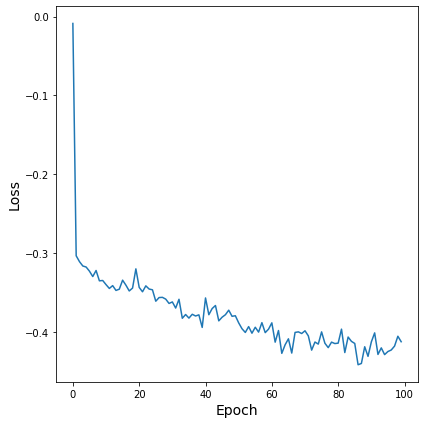

In [0]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(loss_history[:])
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
plt.tight_layout()
plt.show()

In [0]:
for i in range(10):
  print(model.generate_sentence())

['SENTENCE_START', 'song', 'comes', 'course', 'you', 'many', 'get', 'would', 'as', 'sure', 'a', 'could', 'to', 'this', 'the', 'for', 'movies', 'their', 'be', 'movie']
['SENTENCE_START', 'so', 'i', 'got', "'ve", 'would', 'without', 'would', 'knew', 'or', 'a', 'SENTENCE_END']
['SENTENCE_START', 'a', 'movie', 'first', 'seem', ',', 'were', 'and', 'original', 'and', 'in', 'first', 'who', 'of', 'were', 'after', 'he', 'is', 'a', 'is']
['SENTENCE_START', 'getting', 'it', 'has', 'be', 'husband', 'to', 'few', 'without', 'that', '``', ')', 'the', 'i', 'and', 'for', 'edison', 'movie', 'watch', 'been']
['SENTENCE_START', 'everyone', 'zero', 'i', 'was', 'this', 'write', 'grease', 'audience', 'the', 'audience', 'it', 'left', 'be', 'SENTENCE_END']
['SENTENCE_START', 'if', 'he', 'effort', 'out', 'fire', 'which', 'i', 'am', 'hit', 'its', 'it', 'how', 'write', 'you', 'been', "'m", 'than', 'a', 'on']
['SENTENCE_START', 'this', 'it', 'has', 'a', 'is', 'man', 'few', 'time', 'movie', 'written', 'miss', 'and'